# 期末專題: 自拍偵測結合透過偵測手部動作自動套用/切換/取消不同種類濾鏡

## 動機
- 取代自拍時需手動設定倒數計時的困擾
- 出門前自拍棒總會忘記充電，在旅程中自拍棒沒電會造成困擾，透過自拍偵測即不須任何操作即可倒數拍照
- 拍照前選擇濾鏡總需動手襙控選擇很久，選完濾鏡後實際套用到臉上可能也不一定合適，又要重新選。此系統實現預先設定幾種自己常用的濾鏡，鏡頭直接面對臉部下可直接透過手部姿勢來更換預設的濾鏡，省去不少困擾
- 對於數個人一起自拍，總會出現某些人會覺得自己照起來不好看，或者因為角度不好而造成面容不好看。此系統提供了偵測多面孔以及多人手部動作，達成不同人可以有著不同的濾鏡的照片，實現一張照片內客製化每一個人濾鏡的需求，不須透過修圖軟體一個人一個人修圖，也解決了多個人選擇不了最好看的照片而導致的糾紛。
- 可事先設定多種濾鏡，拍照時直接套用，減少了之後一張一張修圖的困擾

## 實作步驟
1. 尋找selfie dataset並訓練出selfie detection model
2. 尋找hand sign dataset並訓練出hand sign classfier model
3. 使用opencv抓取鏡頭內照片
4. 使用MTCNN的進行臉部偵測抓取臉部
5. 使用...進行手部偵測抓取手部
6. 修改現成之MakeUp程式，透過實現臉部濾鏡套入MTCNN擷取出的臉部

參考之AIMakeUp gitHub: https://github.com/QuantumLiu/AIMakeup

## 操作概念
1. 使用者面向鏡頭，偵測到自拍動作後，自動倒數計時10秒，亦可透過手部動作控制倒數計時開始終止
2. 使用者在同時被抓捕到臉部以及手時，會配對最近距離之臉部手部視為同個人，偵測手部動作對該臉部套用對應手勢之濾鏡
3. 使用者可事先設定好數個客製化濾鏡


## 引入套件

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import random
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

try:
    import mtcnn
except:
    !pip install mtcnn    
    import mtcnn

# Selfie Detection

## 資料預處理

### 下載Selfie-Image-Detection-Dataset

In [ ]:
# Download kaggle data in Google Colab
! pip install -q kaggle
from google.colab import files
if(not os.path.exists('./kaggle.json')):
  files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
if(not os.path.exists('./selfie-detection')):
  # Create a folder to store the dataset
  ! mkdir selfie-detection
  # Download the selfieimagedetectiondataset dataset
  ! kaggle datasets download -d jigrubhatt/selfieimagedetectiondataset

100% 2.81G/2.81G [00:21<00:00, 218MB/s]
100% 2.81G/2.81G [00:21<00:00, 143MB/s]


In [ ]:
# Unzip it and store it to the 'selfie-detection' folder
! unzip selfieimagedetectiondataset.zip -d selfie-detection

串流輸出內容已截斷至最後 5000 行。
  inflating: selfie-prediction/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26784.jpg  
  inflating: selfie-prediction/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26785.jpg  
  inflating: selfie-prediction/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26786.jpg  
  inflating: selfie-prediction/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26787.jpg  
  inflating: selfie-prediction/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26788.jpg  
  inflating: selfie-prediction/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26789.jpg  
  inflating: selfie-prediction/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26790.jpg  
  inflating: selfie-prediction/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26791.jpg  
  inflating: selfie-prediction/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26792.jpg 

### 建立訓練，驗證，測試資料集

In [ ]:
# process training data
train_image_dir = Path('./selfie-detection/Selfie-Image-Detection-Dataset/Training_data')
train_filepaths = pd.Series(list(train_image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
train_selfie = pd.Series(train_filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='action').astype(str)
for i in range(len(train_selfie)):
  if train_selfie[i] == 'Selfie':
    train_selfie[i] = 1
  else:
    train_selfie[i] = 0
train_selfie = train_selfie.astype(np.int32)

train_images = pd.concat([train_filepaths, train_selfie], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

# process training data
val_image_dir = Path('./selfie-detection/Selfie-Image-Detection-Dataset/Validation_data')
val_filepaths = pd.Series(list(val_image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
val_selfie = pd.Series(val_filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='action').astype(str)
for i in range(len(val_selfie)):
  if val_selfie[i] == 'Selfie':
    val_selfie[i] = 1
  else:
    val_selfie[i] = 0
val_selfie = val_selfie.astype(np.int32)

val_images = pd.concat([val_filepaths, val_selfie], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

# process testing data
test_image_dir = Path('./selfie-detection/Selfie-Image-Detection-Dataset/Test_data')

test_filepaths = pd.Series(list(test_image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
test_selfie = pd.Series(test_filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='action').astype(str)
for i in range(len(test_selfie)):
  if test_selfie[i] == 'Selfie':
    test_selfie[i] = 1
  else:
    test_selfie[i] = 0
test_selfie = test_selfie.astype(np.int32)

test_images = pd.concat([test_filepaths, test_selfie], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [ ]:
train_images

,Filepath,action
0,selfie-prediction/Selfie-Image-Detection-Datas...,0
1,selfie-prediction/Selfie-Image-Detection-Datas...,1
2,selfie-prediction/Selfie-Image-Detection-Datas...,1
3,selfie-prediction/Selfie-Image-Detection-Datas...,0
4,selfie-prediction/Selfie-Image-Detection-Datas...,0
...,...,...
62890,selfie-prediction/Selfie-Image-Detection-Datas...,1
62891,selfie-prediction/Selfie-Image-Detection-Datas...,0
62892,selfie-prediction/Selfie-Image-Detection-Datas...,0
62893,selfie-prediction/Selfie-Image-Detection-Datas...,1


### 在train_images中取20000個當作訓練資料來加快訓練速度，在validation_images中取6000個當作驗證資料，在test_images中取6000個當作測試資料




In [ ]:
# get specific amount of data
train_df = train_images.sample(20000, random_state=1).reset_index(drop=True)
val_df = val_images.sample(6000, random_state=1).reset_index(drop=True)
test_df = test_images.sample(6000, random_state=1).reset_index(drop=True)

In [ ]:
train_df

,Filepath,action
0,selfie-prediction/Selfie-Image-Detection-Datas...,1
1,selfie-prediction/Selfie-Image-Detection-Datas...,1
2,selfie-prediction/Selfie-Image-Detection-Datas...,0
3,selfie-prediction/Selfie-Image-Detection-Datas...,0
4,selfie-prediction/Selfie-Image-Detection-Datas...,1
...,...,...
19995,selfie-prediction/Selfie-Image-Detection-Datas...,1
19996,selfie-prediction/Selfie-Image-Detection-Datas...,1
19997,selfie-prediction/Selfie-Image-Detection-Datas...,0
19998,selfie-prediction/Selfie-Image-Detection-Datas...,0


### 轉換色彩0到255資料為0到1。

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

### 獲得DataFrameIterator

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath', 
    y_col='action', 
    target_size=(256, 256), 
    color_mode='rgb', 
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42
)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='action',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='action',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)


NameError: ignored

## 建立模型

### 定義模型之函式
#### train_model()
- 使用Adam作為優化函式
- 使用MSE做loss function
- 訓練時加入callback function: 加入early stopping防止過擬合

#### plot_history()
- 將loss，val_loss，epoch繪製圖表

#### evaluate_model()
- 使用RMSE和R-squared評估模型

In [ ]:
# model training, plotting and evaluating
def train_model(model):
    # init and compile the model 
    opt = tf.keras.optimizers.Adam(learning_rate = 0.0001, decay=1e-6)
    model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
    # train
    history = model.fit(train_images, validation_data=val_images, epochs=100, callbacks=[
            tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=5, restore_best_weights=True)
          ]
    )
    plot_history(history)
    evaluate_model(model)

# plotting the loss-epoch function
def plot_history(history):
    print("Accurancy: ", history.history['accuracy'])
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    
# model evaluation with RMSE and R^2 scores
def evaluate_model(model):
    predicted_action = np.squeeze(model.predict(test_images))
    true_action = test_images.labels

    rmse = np.sqrt(model.evaluate(test_images, verbose=0))
    print("Test RMSE: {:.5f}".format(rmse))

    r2 = r2_score(true_action, predicted_action)
    print("Test R^2 Score: {:.5f}".format(r2))

### CNN模型
- 使用CNN
- Activation Layer使用relu函數，去掉負值
- Pooling Layer使用Max Pooling，保留重要資訊，對圖片抗雜訊
- 使用Dropout Layer斷開輸入神經元，用於防止過度擬合，斷開比例:0.2

In [ ]:
my_model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[256,256,3]),
    
    #Block One
    layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    #Block Two
    layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    
    #Block Three
    layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    #Block Four
    layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    #Block Five
    layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    #Head
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
    
])

### 訓練模型

Epoch 1/100
625/625 [==============================] - 153s 243ms/step - loss: 0.0704 - val_loss: 0.1540
Epoch 2/100
625/625 [==============================] - 151s 242ms/step - loss: 0.0567 - val_loss: 0.1908
Epoch 3/100
625/625 [==============================] - 151s 242ms/step - loss: 0.0476 - val_loss: 0.1323
Epoch 4/100
625/625 [==============================] - 151s 242ms/step - loss: 0.0416 - val_loss: 0.1626
Epoch 5/100
625/625 [==============================] - 151s 242ms/step - loss: 0.0376 - val_loss: 0.1971
Epoch 6/100
625/625 [==============================] - 151s 241ms/step - loss: 0.0334 - val_loss: 0.2806
Epoch 7/100
625/625 [==============================] - 151s 241ms/step - loss: 0.0323 - val_loss: 0.0751
Epoch 8/100
625/625 [==============================] - 151s 241ms/step - loss: 0.0296 - val_loss: 0.1795
Epoch 9/100
625/625 [==============================] - 151s 241ms/step - loss: 0.0273 - val_loss: 0.0774
Epoch 10/100
625/625 [==============================] -

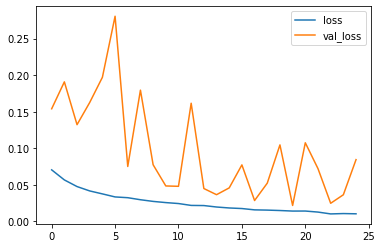

In [ ]:
train_model(my_model)

### 儲存模型

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
my_model.save('./my_model.h5')

In [ ]:
my_model.save('./drive/MyDrive/machine-learning/Selfie-Detection/my_model.h5')

### 載入模型

In [ ]:
reload_model = tf.keras.models.load_model('./my_model.h5')

### 自拍預測

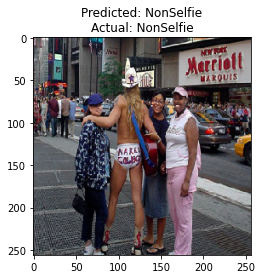

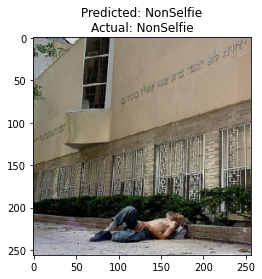

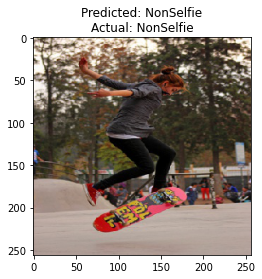

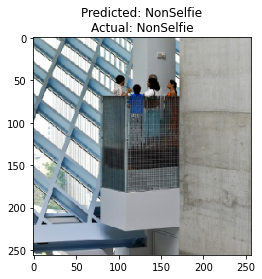

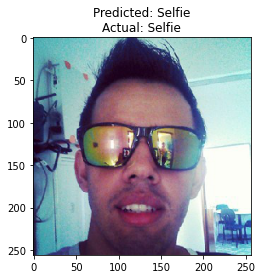

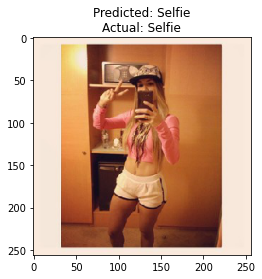

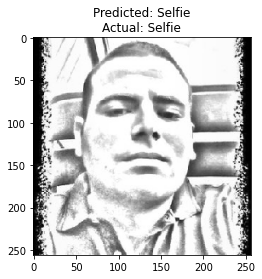

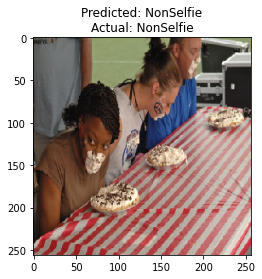

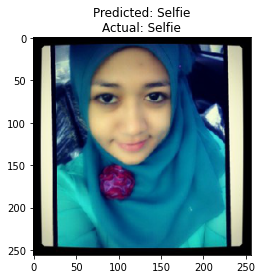

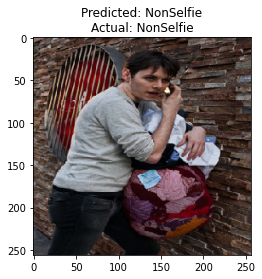

In [ ]:
for i in range(10):
  number = random.randint(0, 6000)
  row = test_df.loc[number]
  filepath = row['Filepath']
  action = row['action']
  image = tf.keras.preprocessing.image.load_img(filepath, target_size=(256,256))
  input_arr = np.array([tf.keras.preprocessing.image.img_to_array(image)]).astype('float32') / 255
  predictions = my_model.predict(input_arr)
  predicted_action = ''
  if(predictions[0][0]>0.5):
    predicted_action='Selfie'
  else:
    predicted_action='NonSelfie'

  plt.figure()
  plt.imshow(image)

  #actual_age = images['Age'][images[images['Filepath'] == test_image].index.values[0]].astype(str)
  if(action==1):
    action='Selfie'
  else:
    action='NonSelfie'
  actual_action = action

  plt.title('Predicted: ' + predicted_action + '\n' +
          'Actual: ' + actual_action)

  plt.show()

### 計算準確度

In [ ]:
result = my_model.predict(test_images)
score = 0;
for i in range(len(result)):
  if result[i] >= 0.5:
    result[i] = 1
  else:
    result[i] = 0
  if result[i] == test_df.loc[i]['action']:
    score = score+1

print("Accurancy {0}%".format((score*100)/len(result)))

Accurancy 97.4%


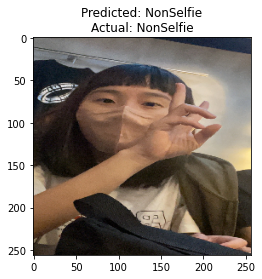

In [ ]:
image = tf.keras.preprocessing.image.load_img('./drive/MyDrive/stranger3.jpg', target_size=(256,256))
input_arr = np.array([tf.keras.preprocessing.image.img_to_array(image)]).astype('float32') / 255
predictions = my_model.predict(input_arr)
predicted_action = ''
if(predictions[0][0]>0.5):
  predicted_action='Selfie'
else:
  predicted_action='NonSelfie'

plt.figure()
plt.imshow(image)

actual_action = 'NonSelfie'

plt.title('Predicted: ' + predicted_action + '\n' +
        'Actual: ' + actual_action)

plt.show()

# Hand Sign Classifier

## 資料預處理

### 下載Selfie-Image-Detection-Dataset

In [ ]:
if(not os.path.exists('./hand-sign-detection')):
  # Create a folder to store the dataset
  ! mkdir hand-sign-detection
  # Download the dataset
  #! kaggle datasets download -d ahmedkhanak1995/sign-language-gesture-images-dataset
  ! kaggle datasets download -d muhammadkhalid/sign-language-for-numbers

 85% 41.0M/48.1M [00:01<00:00, 32.2MB/s]
100% 48.1M/48.1M [00:01<00:00, 32.6MB/s]


In [ ]:
# Unzip it and store it to the 'hand-sign-detection' folder
#! unzip sign-language-gesture-images-dataset.zip -d hand-sign-detection
! unzip sign-language-for-numbers.zip -d hand-sign-detection

串流輸出內容已截斷至最後 5000 行。
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_549.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_55.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_550.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_551.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_552.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_553.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_554.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_555.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_556.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_557.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_558.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_559.jpg  
  inflating: hand-sign-detection/Sign Language for Numbe

### 建立訓練，驗證，測試資料集

In [ ]:
import string
import shutil
from sklearn.utils import shuffle

# process training data
train_image_dir = Path('./hand-sign-detection/Sign Language for Numbers/')
alphabets = list(string.ascii_uppercase)
if(os.path.exists('./hand-sign-detection/Sign Language for Numbers/unknown')):
  shutil.rmtree('./hand-sign-detection/Sign Language for Numbers/unknown')

train_filepaths = pd.Series(list(train_image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
train_hand = pd.Series(train_filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='sign').astype(np.int32)
train_images = shuffle(pd.concat([train_filepaths, train_hand], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True))

val_images = train_images[9000:12000]
test_images = train_images[12000:15000]
train_images = train_images[0:9000]

In [ ]:
train_images

,Filepath,sign
14083,hand-sign-detection/Sign Language for Numbers/...,2
6310,hand-sign-detection/Sign Language for Numbers/...,9
574,hand-sign-detection/Sign Language for Numbers/...,4
469,hand-sign-detection/Sign Language for Numbers/...,7
7433,hand-sign-detection/Sign Language for Numbers/...,5
...,...,...
5346,hand-sign-detection/Sign Language for Numbers/...,9
9801,hand-sign-detection/Sign Language for Numbers/...,6
643,hand-sign-detection/Sign Language for Numbers/...,7
1690,hand-sign-detection/Sign Language for Numbers/...,4


In [ ]:
# get specific amount of data
train_df = train_images.sample(9000, random_state=1).reset_index(drop=True)
val_df = val_images.sample(3000, random_state=1).reset_index(drop=True)
test_df = test_images.sample(3000, random_state=1).reset_index(drop=True)

### 轉換色彩0到255資料為0到1。

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

### 獲得DataFrameIterator

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath', 
    y_col='sign', 
    target_size=(256, 256),
    color_mode='rgb', 
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42
)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='sign',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='sign',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)


Found 9000 validated image filenames.
Found 3000 validated image filenames.
Found 3000 validated image filenames.


## 建立模型

### VGG19模型

In [ ]:
hand_model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[256,256,3]),
    
    #Block One
    layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    #Block Two
    layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    
    #Block Three
    layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    #Block Four
    layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    #Block Five
    layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    #Head
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='linear')
    
])

### 訓練模型

Epoch 1/100
282/282 [==============================] - 64s 224ms/step - loss: 1.8710 - accuracy: 0.1058 - val_loss: 5.2061 - val_accuracy: 0.1033
Epoch 2/100
282/282 [==============================] - 64s 225ms/step - loss: 1.5619 - accuracy: 0.1121 - val_loss: 3.1812 - val_accuracy: 0.1013
Epoch 3/100
282/282 [==============================] - 64s 226ms/step - loss: 1.4034 - accuracy: 0.1120 - val_loss: 2.7253 - val_accuracy: 0.0657
Epoch 4/100
282/282 [==============================] - 64s 227ms/step - loss: 1.2243 - accuracy: 0.1168 - val_loss: 1.8436 - val_accuracy: 0.0813
Epoch 5/100
282/282 [==============================] - 64s 227ms/step - loss: 1.0864 - accuracy: 0.1174 - val_loss: 3.3713 - val_accuracy: 0.1017
Epoch 6/100
282/282 [==============================] - 64s 227ms/step - loss: 1.0013 - accuracy: 0.1082 - val_loss: 1.2964 - val_accuracy: 0.0817
Epoch 7/100
282/282 [==============================] - 64s 228ms/step - loss: 0.8726 - accuracy: 0.1089 - val_loss: 2.4289 -

TypeError: ignored

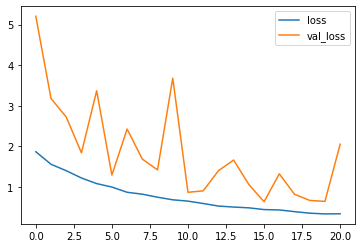

In [ ]:
train_model(hand_model)

In [ ]:
hand_model_VGG19.save('./hand_model.h5')

[[7.6001163]]


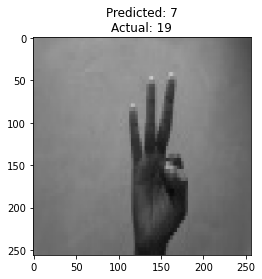

In [ ]:
image = tf.keras.preprocessing.image.load_img('./hand-sign-detection/Sign Language for Numbers/9/nine_1005.jpg', target_size=(256,256))
input_arr = np.array([tf.keras.preprocessing.image.img_to_array(image)]).astype('float32') / 255
predictions = hand_model_VGG19.predict(input_arr)

print(predictions)
plt.figure()
plt.imshow(image)


predicted_sign = predictions[0][0].astype(np.int32).astype(str)
#actual_sign = test_images['sign'][test_images[test_images['Filepath'] == test_image].index.values[0]].astype(str)
actual_sign = '19'


plt.title('Predicted: ' + predicted_sign + '\n' +
        'Actual: ' + actual_sign)

plt.show()

# Opencv抓取鏡頭照片

## 引入套件

In [52]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

try:
    import mediapipe
except:
    !pip install mediapipe    
    import mediapipe

try:
    import cvzone
except:
    !pip install cvzone    
    import cvzone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.3 MB/s 


## helper funcitons

In [2]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [3]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [4]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
hand_cascade = cv2.CascadeClassifier('./hand.xml')

In [5]:
from cvzone.HandTrackingModule import HandDetector
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
detector = HandDetector(detectionCon=0.8)
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])


    hands, img = detector.findHands(img)
    print(hands)
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    hands = hand_cascade.detectMultiScale(gray)

    # get face bounding box for overlay
    
    
    for (x,y,w,h) in hands:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      cv2.putText(bbox_array, "hand", (x, y+h - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (255, 215, 0), 2)
    

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

NameError: name 'Javascript' is not defined

In [2]:
import cv2
from cvzone.HandTrackingModule import HandDetector

# 選擇第一隻攝影機
cap = cv2.VideoCapture(0)
img = cv2.imread("Selfie38976.jpg")

if cap.isOpened():
    print("is opened!")
    while True:
        # 從攝影機擷取一張影像
        ret,frame = cap.read()
        if not ret:
            print("ret is false")
            continue
        else:
            # 開新視窗顯示圖片
            cv2.imshow('frame', img)
        
        # 釋放攝影機
cap.release()
cv2.waitKey(0) # 暫停等待按鍵，使 cv2.imshow 能顯示出畫面
cv2.destroyAllWindows() # 配合上一行，按下任意鍵則關閉所有視窗 (使用 OpenCV 內建的方法)




: 

: 

In [2]:
import cv2

img = cv2.imread("Selfie38976.jpg")
print(img.shape)
cv2.imshow('frame', img)


cv2.waitKey(0) # 暫停等待按鍵，使 cv2.imshow 能顯示出畫面
cv2.destroyAllWindows() # 配合上一行，按下任意鍵則關閉所有視窗 (使用 OpenCV 內建的方法)



(306, 306, 3)
